<h2>QAOA For Max-Cut<h/2>

In [1]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import itertools

np.random.seed(42)

In [2]:
# Convert bitstring (array of 0/1) -> integer
def bitstring_to_int(bits):
    return int("".join(str(b) for b in bits), 2)

# Compute cut value for a bitstring
def compute_cut_value(G, bitstring):
    cut = 0
    for u, v in G.edges():
        if bitstring[u] != bitstring[v]:
            cut += 1
    return cut


In [3]:
def draw_graph(G, title="Graph"):
    plt.figure(figsize=(4,4))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=800, font_size=12,
            node_color="skyblue", edge_color="gray")
    plt.title(title)
    plt.show()

def draw_graph_cut(G, bitstring, title="MaxCut Result"):
    plt.figure(figsize=(4,4))
    pos = nx.spring_layout(G, seed=42)
    
    # color nodes by partition
    colors = ["orange" if bitstring[n] == 1 else "skyblue" for n in G.nodes()]
    
    nx.draw(G, pos, with_labels=True, node_size=800, font_size=12,
            node_color=colors, edge_color="gray")
    
    cut_edges = [(u, v) for u, v in G.edges() if bitstring[u] != bitstring[v]]
    nx.draw_networkx_edges(G, pos, edgelist=cut_edges, edge_color="red", width=3)

    plt.title(f"{title} | Cut = {compute_cut_value(G, bitstring)}")
    plt.show()


In [4]:
def cost_unitary(gamma, G):
    """Apply U_C(γ) for MaxCut."""
    for (u, v) in G.edges():
        qml.CNOT(wires=[u, v])
        qml.RZ(gamma, wires=v)
        qml.CNOT(wires=[u, v])

def mixer_unitary(beta, n_qubits):
    """Apply U_B(β)."""
    for q in range(n_qubits):
        qml.RX(2 * beta, wires=q)

def qaoa_circuit(gammas, betas, G, return_samples=False, shots=100):
    n_qubits = len(G.nodes())
    dev = qml.device("lightning.qubit", wires=n_qubits, shots=shots)

    @qml.qnode(dev)
    def circuit(gammas, betas, return_samples=False):
        # Start in uniform superposition
        for q in range(n_qubits):
            qml.Hadamard(wires=q)

        # Apply layers
        for gamma, beta in zip(gammas, betas):
            cost_unitary(gamma, G)
            mixer_unitary(beta, n_qubits)

        if return_samples:
            return qml.sample()
        
        # Expectation value of cost Hamiltonian
        C = qml.sum(*(qml.Z(u) @ qml.Z(v) for u, v in G.edges()))
        return qml.expval(C)

    return circuit


In [5]:
def objective(params, circuit, G):
    gammas, betas = params
    expval = circuit(gammas, betas, return_samples=False)
    # MaxCut objective mapping
    return -0.5 * (len(G.edges()) - expval)

def run_qaoa(G, p=1, steps=40):
    n_qubits = len(G.nodes())
    circuit = qaoa_circuit(np.zeros(p), np.zeros(p), G)

    # Initialize parameters near zero
    params = 0.01 * np.random.rand(2, p, requires_grad=True)
    opt = qml.AdagradOptimizer(stepsize=0.5)

    # Optimization loop
    for i in range(steps):
        params = opt.step(lambda pr: objective(pr, circuit, G), params)
        if (i+1) % 10 == 0:
            val = -objective(params, circuit, G)
            print(f"p={p} | Step {i+1} | Objective ≈ {val:.6f}")

    # Sample final circuit
    final_circuit = qaoa_circuit(params[0], params[1], G, shots=200)
    samples = final_circuit(params[0], params[1], return_samples=True)

    return params, samples, final_circuit


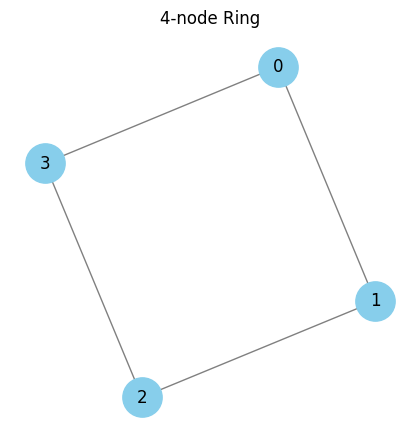

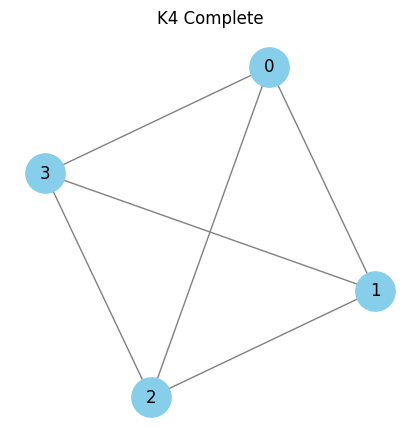

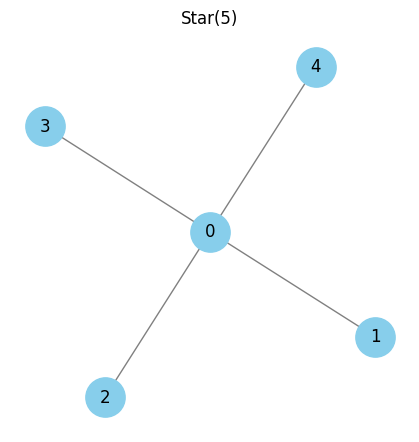

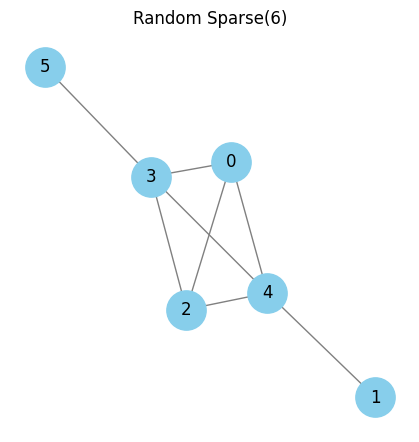

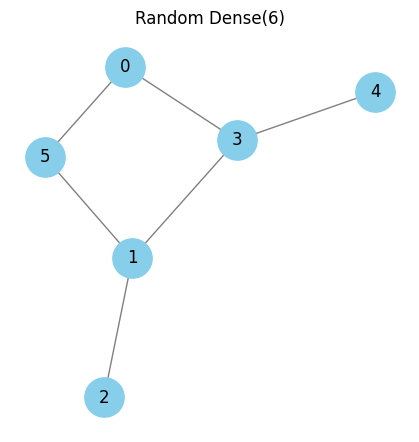

In [6]:
graphs = {}

# Graph A: 4-node ring
G_ring = nx.Graph([(0,1), (1,2), (2,3), (3,0)])
graphs["4-node Ring"] = G_ring

# Graph B: K4 complete graph
G_K4 = nx.complete_graph(4)
graphs["K4 Complete"] = G_K4

# Graph C: Star graph with 5 nodes
G_star = nx.star_graph(4)  # nodes 0–4, center 0
graphs["Star(5)"] = G_star

# Graph D: Sparse random 6-node
G_sparse = nx.gnp_random_graph(6, 0.3, seed=42)
graphs["Random Sparse(6)"] = G_sparse

# Graph E: Dense random 6-node
G_dense = nx.gnp_random_graph(6, 0.7, seed=24)
graphs["Random Dense(6)"] = G_dense

# Show all graphs
for name, G in graphs.items():
    draw_graph(G, title=name)


In [7]:
results = {}

for name, G in graphs.items():
    print("\n" + "="*60)
    print(f"Running QAOA on {name}")
    print("="*60)

    results[name] = {}

    # p = 1
    print("\n--- p = 1 ---")
    params1, samples1, circ1 = run_qaoa(G, p=1)
    results[name]["p1"] = (params1, samples1)

    # p = 2
    print("\n--- p = 2 ---")
    params2, samples2, circ2 = run_qaoa(G, p=2)
    results[name]["p2"] = (params2, samples2)



Running QAOA on 4-node Ring

--- p = 1 ---


C:\Users\ADMIN\anaconda3\envs\pytorch_env\Lib\site-packages\pennylane\devices\device_api.py:193: PennyLaneDeprecationWarning: Setting shots on device is deprecated. Please use the `set_shots` transform on the respective QNode instead.
  warnings.warn(


p=1 | Step 10 | Objective ≈ 2.920000
p=1 | Step 20 | Objective ≈ 3.080000
p=1 | Step 30 | Objective ≈ 3.120000
p=1 | Step 40 | Objective ≈ 2.860000

--- p = 2 ---
p=2 | Step 10 | Objective ≈ 3.780000
p=2 | Step 20 | Objective ≈ 4.000000
p=2 | Step 30 | Objective ≈ 4.000000
p=2 | Step 40 | Objective ≈ 4.000000

Running QAOA on K4 Complete

--- p = 1 ---
p=1 | Step 10 | Objective ≈ 3.680000
p=1 | Step 20 | Objective ≈ 3.720000
p=1 | Step 30 | Objective ≈ 3.690000
p=1 | Step 40 | Objective ≈ 3.710000

--- p = 2 ---
p=2 | Step 10 | Objective ≈ 3.690000
p=2 | Step 20 | Objective ≈ 3.570000
p=2 | Step 30 | Objective ≈ 3.630000
p=2 | Step 40 | Objective ≈ 3.700000

Running QAOA on Star(5)

--- p = 1 ---
p=1 | Step 10 | Objective ≈ 2.910000
p=1 | Step 20 | Objective ≈ 3.070000
p=1 | Step 30 | Objective ≈ 2.950000
p=1 | Step 40 | Objective ≈ 2.920000

--- p = 2 ---
p=2 | Step 10 | Objective ≈ 2.790000
p=2 | Step 20 | Objective ≈ 2.920000
p=2 | Step 30 | Objective ≈ 3.090000
p=2 | Step 40 | Obje


################################################################################
RESULTS FOR: 4-node Ring
################################################################################

QAOA p=1: Most frequent bitstring = 0101
Cut value = 4


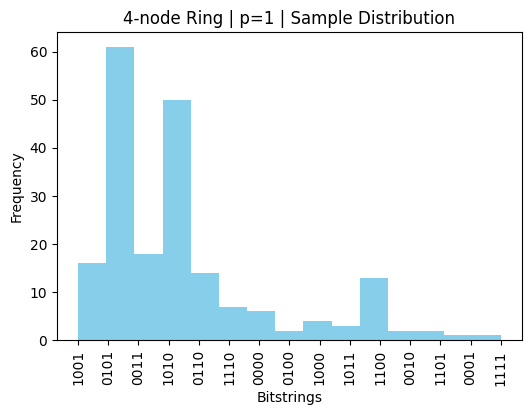

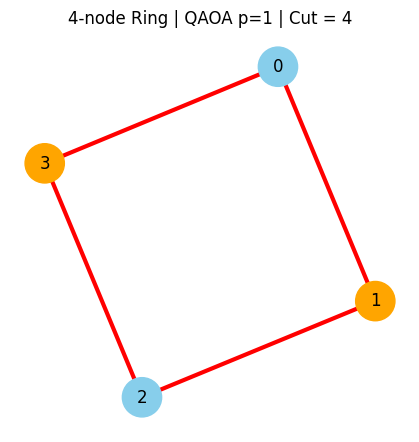


QAOA p=2: Most frequent bitstring = 1010
Cut value = 4


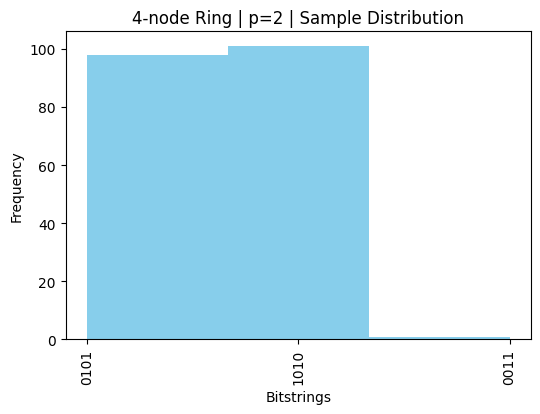

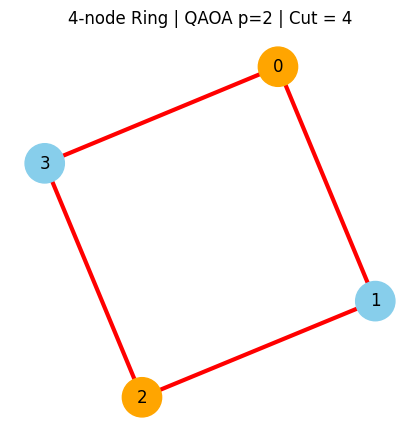


################################################################################
RESULTS FOR: K4 Complete
################################################################################

QAOA p=1: Most frequent bitstring = 1001
Cut value = 4


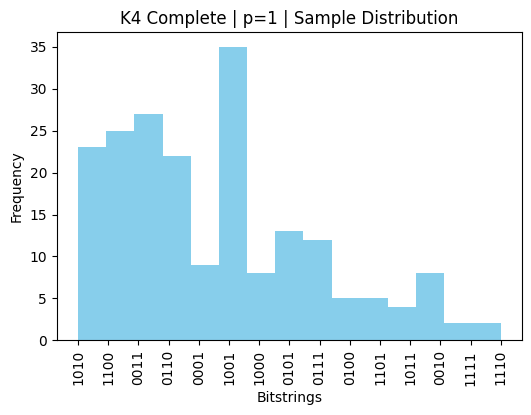

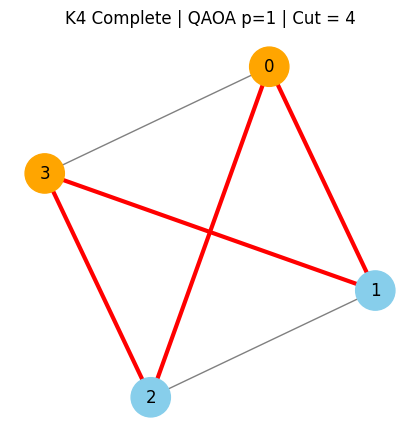


QAOA p=2: Most frequent bitstring = 0011
Cut value = 4


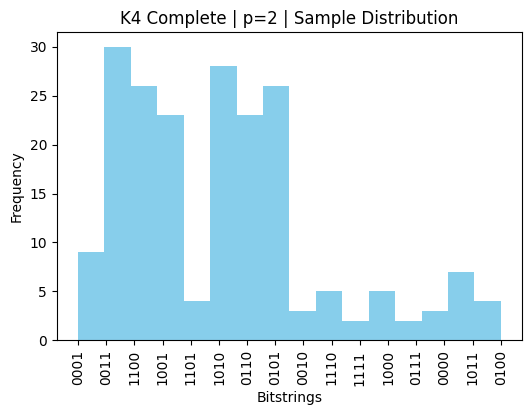

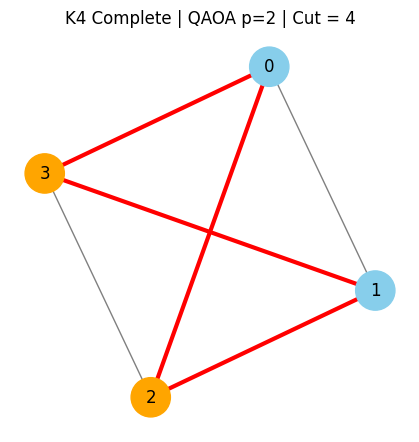


################################################################################
RESULTS FOR: Star(5)
################################################################################

QAOA p=1: Most frequent bitstring = 10000
Cut value = 4


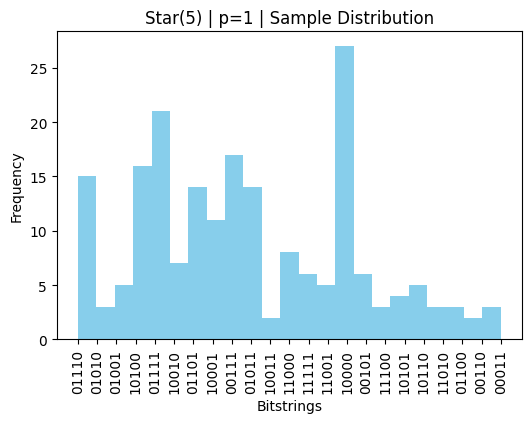

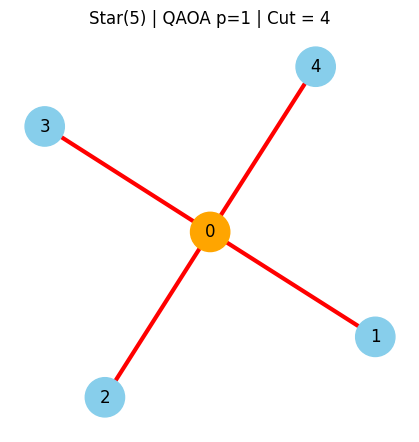


QAOA p=2: Most frequent bitstring = 10000
Cut value = 4


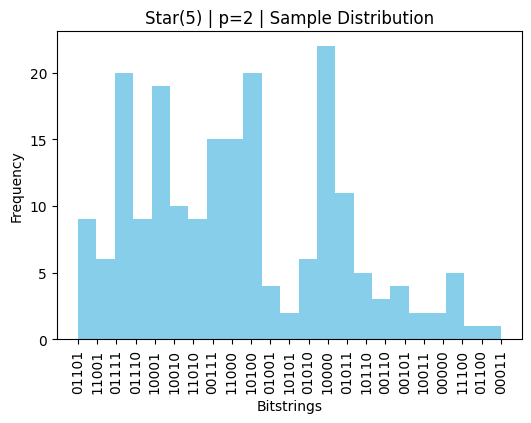

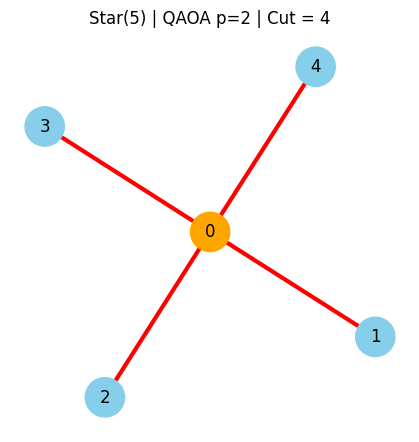


################################################################################
RESULTS FOR: Random Sparse(6)
################################################################################

QAOA p=1: Most frequent bitstring = 100011
Cut value = 6


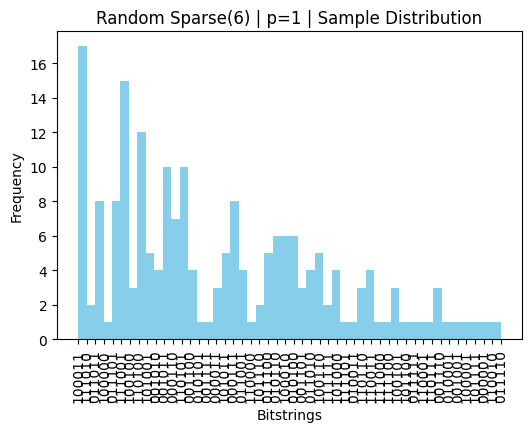

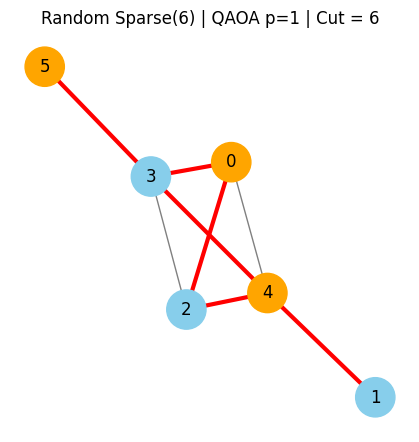


QAOA p=2: Most frequent bitstring = 001011
Cut value = 6


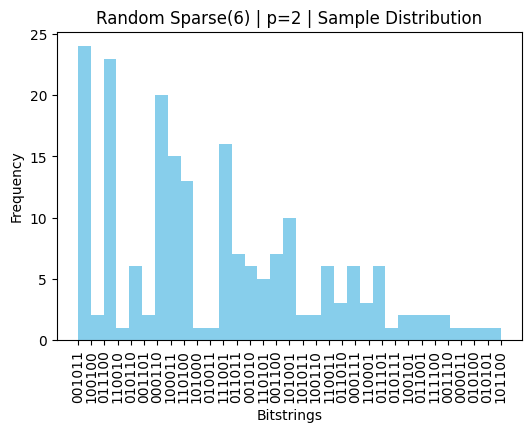

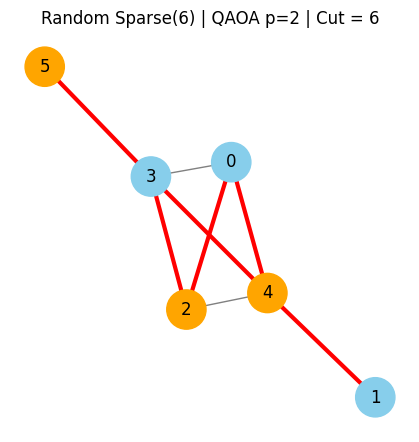


################################################################################
RESULTS FOR: Random Dense(6)
################################################################################

QAOA p=1: Most frequent bitstring = 110010
Cut value = 6


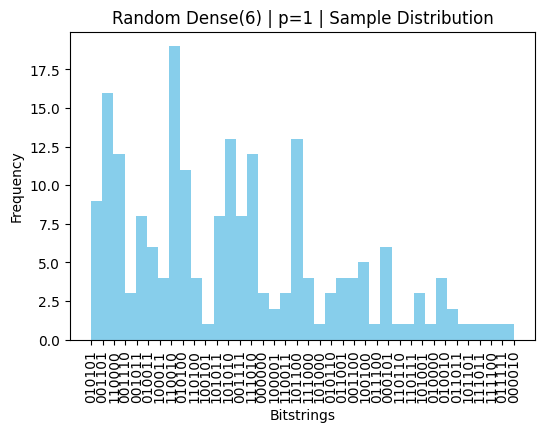

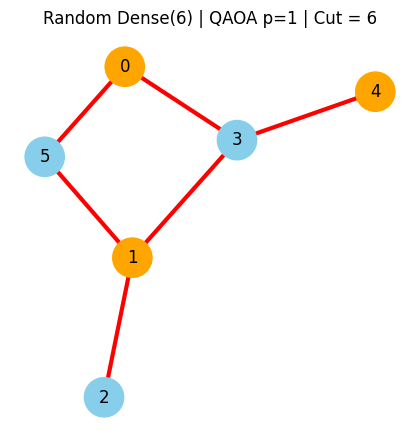


QAOA p=2: Most frequent bitstring = 110010
Cut value = 6


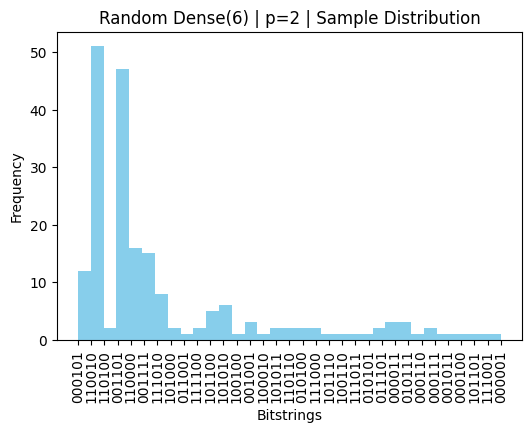

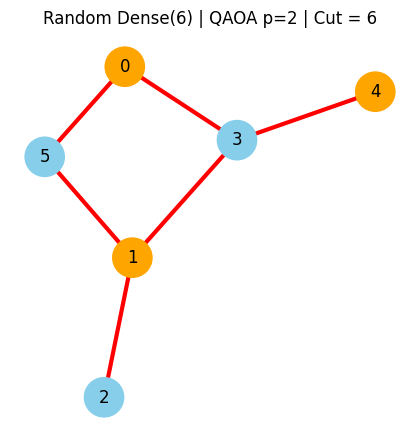

In [8]:
for name, G in graphs.items():

    print("\n" + "#"*80)
    print(f"RESULTS FOR: {name}")
    print("#"*80)

    for p in [1, 2]:
        params, samples = results[name][f"p{p}"]

        # Convert to bitstrings
        bitstrings = [tuple(sample) for sample in samples]
        strings = ["".join(str(b) for b in bits) for bits in bitstrings]
        
        # Count frequencies
        vals, counts = np.unique(strings, return_counts=True)
        most_freq = vals[np.argmax(counts)]
        best_bits = np.array([int(b) for b in most_freq])

        print(f"\nQAOA p={p}: Most frequent bitstring = {most_freq}")
        print(f"Cut value = {compute_cut_value(G, best_bits)}")

        # Plot histogram
        plt.figure(figsize=(6,4))
        plt.title(f"{name} | p={p} | Sample Distribution")
        plt.hist(strings, bins=len(vals), color="skyblue")
        plt.xticks(rotation=90)
        plt.xlabel("Bitstrings")
        plt.ylabel("Frequency")
        plt.show()

        # Draw max cut visualization
        draw_graph_cut(G, best_bits, title=f"{name} | QAOA p={p}")



In [9]:
# --- QAOA Circuit Plotting Tools ---

def build_qaoa_circuit_for_drawing(gammas, betas, G):
    """
    Build a QAOA circuit (no shots) only for circuit drawing.
    """
    n_qubits = len(G.nodes())
    dev = qml.device("lightning.qubit", wires=n_qubits, shots=None)

    @qml.qnode(dev)
    def circuit():
        # Start in |+>
        for q in range(n_qubits):
            qml.Hadamard(wires=q)

        # Apply p layers
        for gamma, beta in zip(gammas, betas):
            cost_unitary(gamma, G)
            mixer_unitary(beta, n_qubits)

        return qml.state()

    return circuit


def plot_qaoa_circuit_ascii(gammas, betas, G):
    """
    Print ASCII-style circuit diagram.
    """
    circuit = build_qaoa_circuit_for_drawing(gammas, betas, G)
    print(qml.draw(circuit)())  # ASCII version


def plot_qaoa_circuit_mpl(gammas, betas, G):
    """
    Display a matplotlib-rendered circuit diagram.
    """
    circuit = build_qaoa_circuit_for_drawing(gammas, betas, G)
    fig, ax = qml.draw_mpl(circuit)()
    fig.set_size_inches(12, 4)
    plt.show()



QAOA CIRCUITS FOR p = 1

------------------------------------------------------------
Graph: 4-node Ring   |   p = 1
------------------------------------------------------------

ASCII Circuit Diagram:
----------------------
0: ──H─╭●───────────╭●─╭●───────────╭●──RX(-0.79)───────────────────────────────────── ···
1: ──H─╰X──RZ(0.76)─╰X─│────────────│──╭●───────────────────╭●──RX(-0.79)───────────── ···
2: ──H─────────────────│────────────│──╰X──────────RZ(0.76)─╰X─╭●───────────────────╭● ···
3: ──H─────────────────╰X──RZ(0.76)─╰X─────────────────────────╰X──────────RZ(0.76)─╰X ···

0: ··· ────────────┤  State
1: ··· ────────────┤  State
2: ··· ──RX(-0.79)─┤  State
3: ··· ──RX(-0.79)─┤  State

Matplotlib Circuit Diagram:
---------------------------


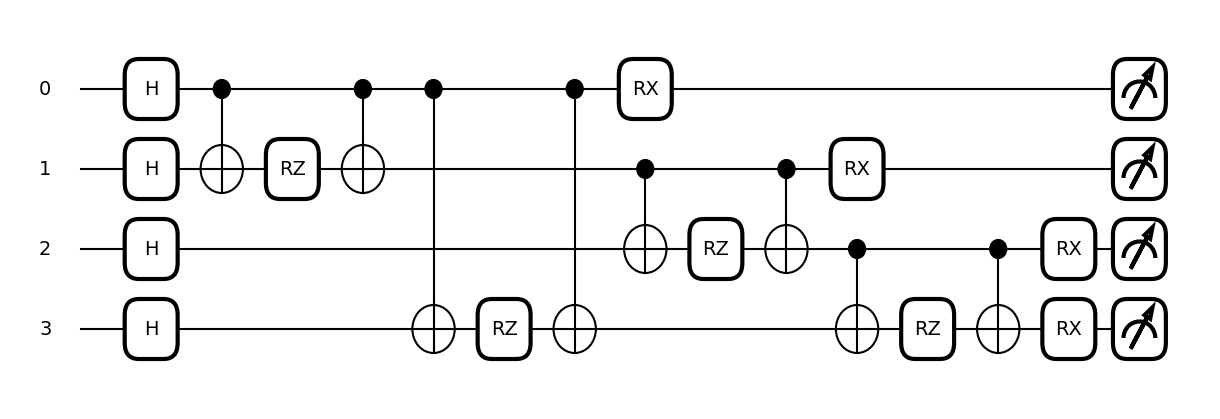




------------------------------------------------------------
Graph: K4 Complete   |   p = 1
------------------------------------------------------------

ASCII Circuit Diagram:
----------------------
0: ──H─╭●───────────╭●─╭●───────────╭●─╭●───────────╭●──RX(-0.61)───────────────────────────── ···
1: ──H─╰X──RZ(0.46)─╰X─│────────────│──│────────────│──╭●───────────────────╭●─╭●───────────╭● ···
2: ──H─────────────────╰X──RZ(0.46)─╰X─│────────────│──╰X──────────RZ(0.46)─╰X─│────────────│─ ···
3: ──H─────────────────────────────────╰X──RZ(0.46)─╰X─────────────────────────╰X──RZ(0.46)─╰X ···

0: ··· ────────────────────────────────────┤  State
1: ··· ──RX(-0.61)─────────────────────────┤  State
2: ··· ─╭●───────────────────╭●──RX(-0.61)─┤  State
3: ··· ─╰X──────────RZ(0.46)─╰X──RX(-0.61)─┤  State

Matplotlib Circuit Diagram:
---------------------------


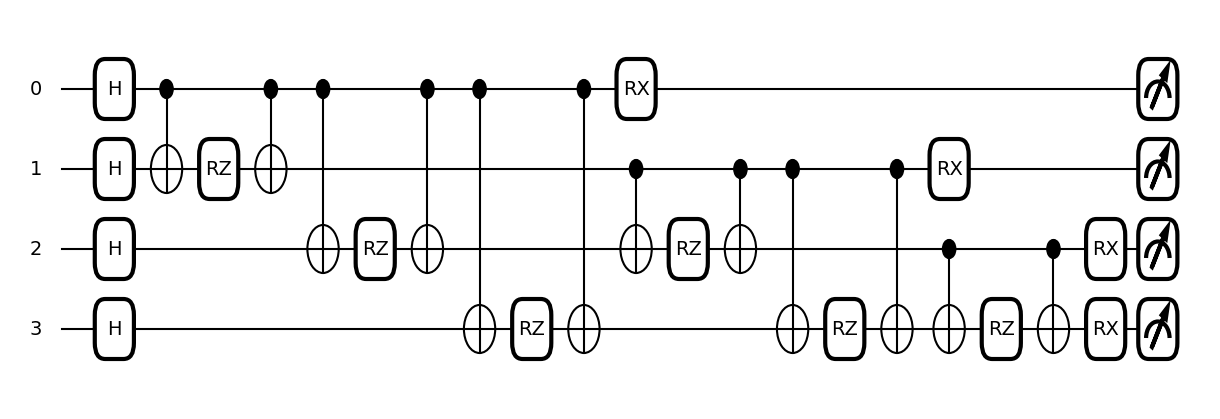




------------------------------------------------------------
Graph: Star(5)   |   p = 1
------------------------------------------------------------

ASCII Circuit Diagram:
----------------------
0: ──H─╭●────────────╭●─╭●────────────╭●─╭●────────────╭●─╭●────────────╭●──RX(-2.40)─┤  State
1: ──H─╰X──RZ(-0.95)─╰X─│─────────────│──│─────────────│──│─────────────│───RX(-2.40)─┤  State
2: ──H──────────────────╰X──RZ(-0.95)─╰X─│─────────────│──│─────────────│───RX(-2.40)─┤  State
3: ──H───────────────────────────────────╰X──RZ(-0.95)─╰X─│─────────────│───RX(-2.40)─┤  State
4: ──H────────────────────────────────────────────────────╰X──RZ(-0.95)─╰X──RX(-2.40)─┤  State

Matplotlib Circuit Diagram:
---------------------------


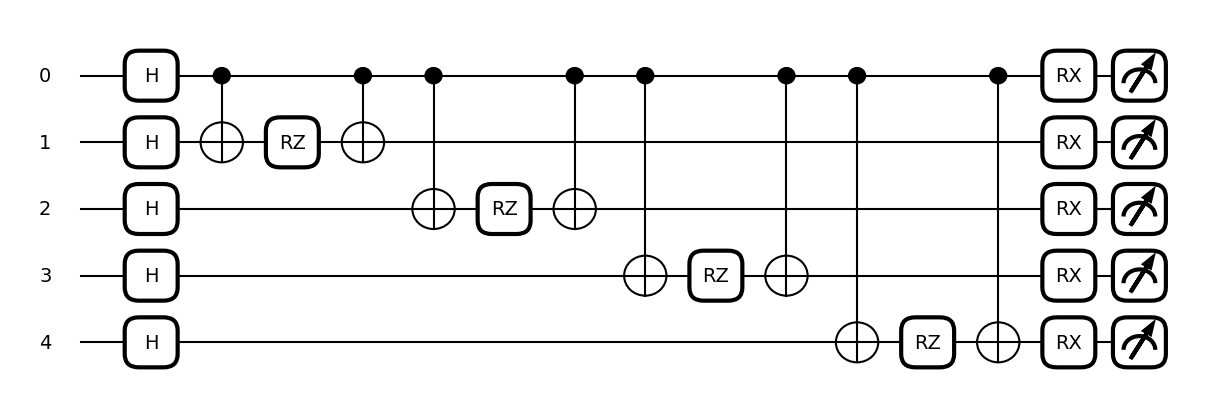




------------------------------------------------------------
Graph: Random Sparse(6)   |   p = 1
------------------------------------------------------------

ASCII Circuit Diagram:
----------------------
0: ──H─╭●────────────╭●─╭●────────────╭●─╭●────────────╭●──RX(-2.45)───────────────────────── ···
1: ──H─│─────────────│──│─────────────│──│─────────────│──╭●────────────────────╭●──RX(-2.45) ···
2: ──H─╰X──RZ(-0.53)─╰X─│─────────────│──│─────────────│──│─────────────────────│──╭●──────── ···
3: ──H──────────────────╰X──RZ(-0.53)─╰X─│─────────────│──│─────────────────────│──╰X──────── ···
4: ──H───────────────────────────────────╰X──RZ(-0.53)─╰X─╰X──────────RZ(-0.53)─╰X─────────── ···
5: ──H─────────────────────────────────────────────────────────────────────────────────────── ···

0: ··· ─────────────────────────────────────────────────────────────────────────────────────┤  State
1: ··· ─────────────────────────────────────────────────────────────────────────────────────┤  State
2

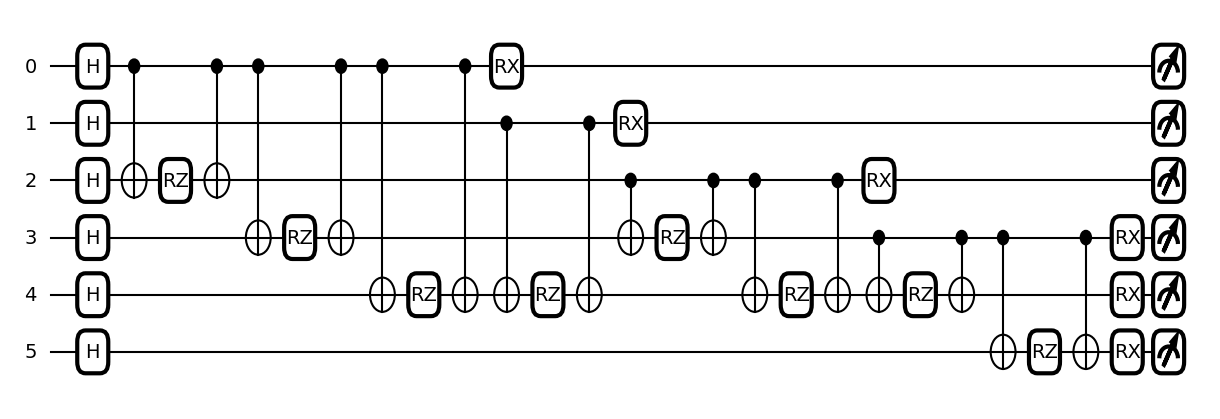




------------------------------------------------------------
Graph: Random Dense(6)   |   p = 1
------------------------------------------------------------

ASCII Circuit Diagram:
----------------------
0: ──H─╭●────────────╭●─╭●────────────╭●──RX(-2.45)───────────────────────────────────────────── ···
1: ──H─│─────────────│──│─────────────│──╭●────────────────────╭●─╭●────────────╭●─╭●─────────── ···
2: ──H─│─────────────│──│─────────────│──╰X──────────RZ(-0.78)─╰X─│─────────────│──│──────────── ···
3: ──H─╰X──RZ(-0.78)─╰X─│─────────────│───────────────────────────╰X──RZ(-0.78)─╰X─│──────────── ···
4: ──H──────────────────│─────────────│────────────────────────────────────────────│──────────── ···
5: ──H──────────────────╰X──RZ(-0.78)─╰X───────────────────────────────────────────╰X──RZ(-0.78) ···

0: ··· ────────────────────────────────────────┤  State
1: ··· ─╭●──RX(-2.45)──────────────────────────┤  State
2: ··· ─│───RX(-2.45)──────────────────────────┤  State
3: ··· ─│──╭●─────

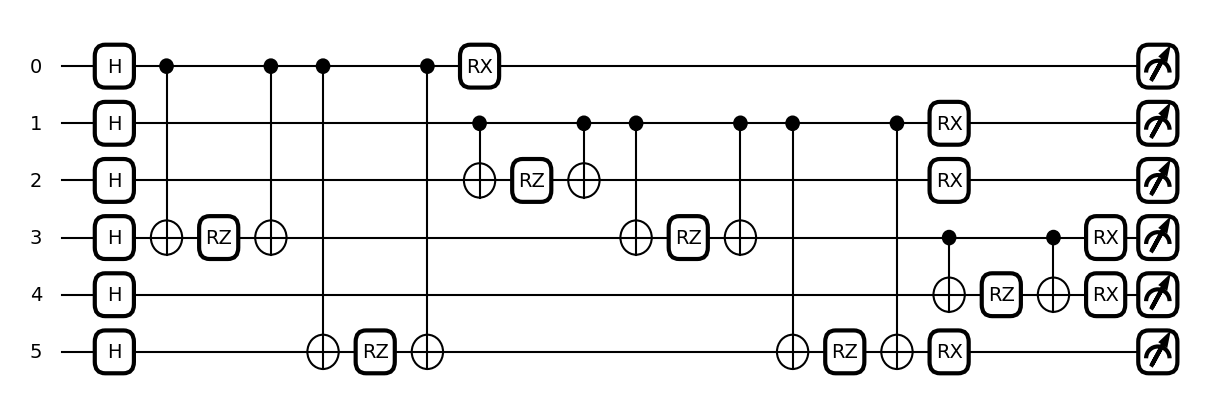




QAOA CIRCUITS FOR p = 2

------------------------------------------------------------
Graph: 4-node Ring   |   p = 2
------------------------------------------------------------

ASCII Circuit Diagram:
----------------------
0: ──H─╭●────────────╭●─╭●────────────╭●──RX(-0.79)──────────────────────────╭●──────── ···
1: ──H─╰X──RZ(-1.56)─╰X─│─────────────│──╭●────────────────────╭●──RX(-0.79)─╰X──────── ···
2: ──H──────────────────│─────────────│──╰X──────────RZ(-1.56)─╰X─╭●─────────────────── ···
3: ──H──────────────────╰X──RZ(-1.56)─╰X──────────────────────────╰X──────────RZ(-1.56) ···

0: ··· ───────────╭●─────────╭●───────────╭●──RX(1.62)──────────────────────────────────── ···
1: ··· ──RZ(0.77)─╰X─────────│────────────│──╭●──────────────────╭●──RX(1.62)───────────── ···
2: ··· ─╭●─────────RX(-0.79)─│────────────│──╰X─────────RZ(0.77)─╰X─╭●──────────────────╭● ···
3: ··· ─╰X─────────RX(-0.79)─╰X──RZ(0.77)─╰X────────────────────────╰X─────────RZ(0.77)─╰X ···

0: ··· ───────────┤  S

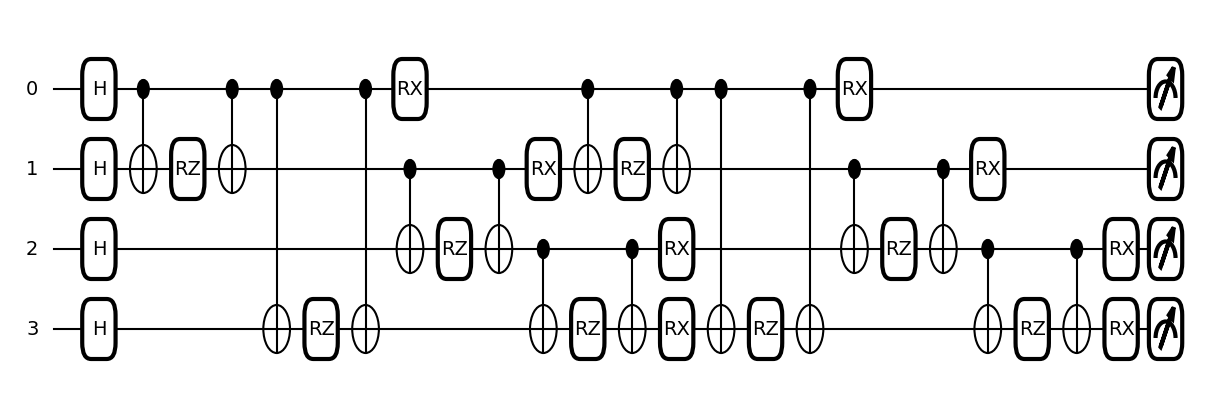




------------------------------------------------------------
Graph: K4 Complete   |   p = 2
------------------------------------------------------------

ASCII Circuit Diagram:
----------------------
0: ──H─╭●───────────╭●─╭●───────────╭●─╭●───────────╭●──RX(-1.72)───────────────────────────── ···
1: ──H─╰X──RZ(0.73)─╰X─│────────────│──│────────────│──╭●───────────────────╭●─╭●───────────╭● ···
2: ──H─────────────────╰X──RZ(0.73)─╰X─│────────────│──╰X──────────RZ(0.73)─╰X─│────────────│─ ···
3: ──H─────────────────────────────────╰X──RZ(0.73)─╰X─────────────────────────╰X──RZ(0.73)─╰X ···

0: ··· ────────────╭●───────────────────╭●─────────╭●────────────╭●─╭●────────────╭●──RX(-2.32) ···
1: ··· ──RX(-1.72)─╰X─────────RZ(-0.21)─╰X─────────│─────────────│──│─────────────│──╭●──────── ···
2: ··· ─╭●───────────────────╭●──────────RX(-1.72)─╰X──RZ(-0.21)─╰X─│─────────────│──╰X──────── ···
3: ··· ─╰X──────────RZ(0.73)─╰X──────────RX(-1.72)──────────────────╰X──RZ(-0.21)─╰X─────────── ···


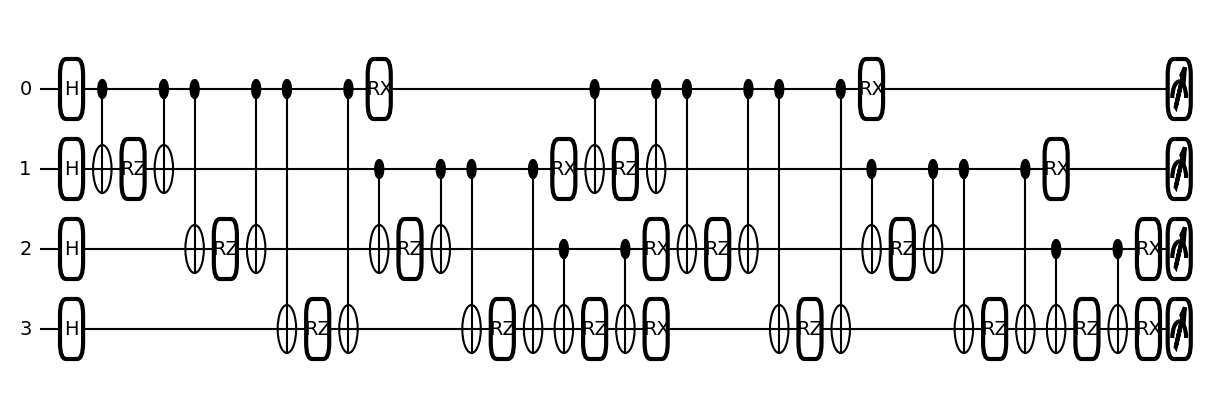




------------------------------------------------------------
Graph: Star(5)   |   p = 2
------------------------------------------------------------

ASCII Circuit Diagram:
----------------------
0: ──H─╭●────────────╭●─╭●────────────╭●─╭●────────────╭●─╭●────────────╭●──RX(-0.54)─╭● ···
1: ──H─╰X──RZ(-0.84)─╰X─│─────────────│──│─────────────│──│─────────────│───RX(-0.54)─╰X ···
2: ──H──────────────────╰X──RZ(-0.84)─╰X─│─────────────│──│─────────────│───RX(-0.54)─── ···
3: ──H───────────────────────────────────╰X──RZ(-0.84)─╰X─│─────────────│───RX(-0.54)─── ···
4: ──H────────────────────────────────────────────────────╰X──RZ(-0.84)─╰X──RX(-0.54)─── ···

0: ··· ───────────╭●─╭●───────────╭●─╭●───────────╭●─╭●───────────╭●──RX(1.30)─┤  State
1: ··· ──RZ(0.21)─╰X─│────────────│──│────────────│──│────────────│───RX(1.30)─┤  State
2: ··· ──────────────╰X──RZ(0.21)─╰X─│────────────│──│────────────│───RX(1.30)─┤  State
3: ··· ──────────────────────────────╰X──RZ(0.21)─╰X─│────────────│───R

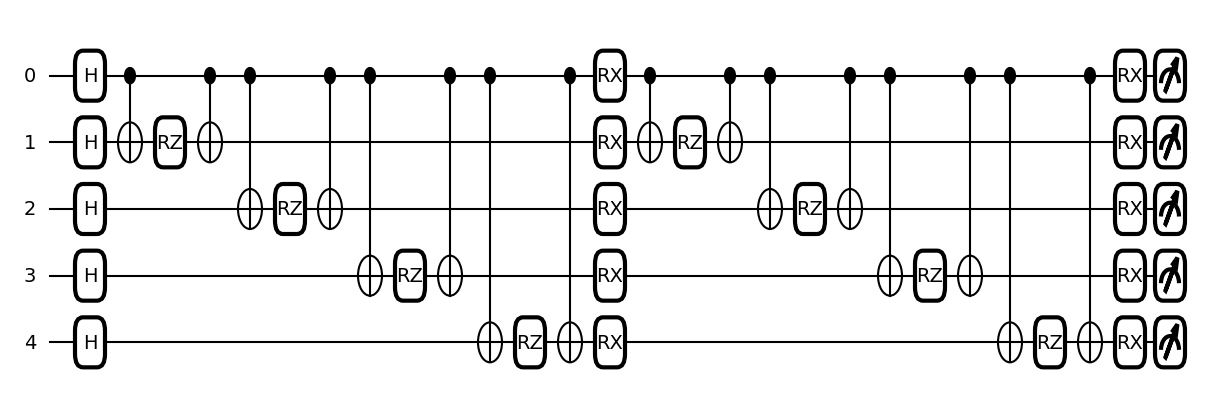




------------------------------------------------------------
Graph: Random Sparse(6)   |   p = 2
------------------------------------------------------------

ASCII Circuit Diagram:
----------------------
0: ──H─╭●───────────╭●─╭●───────────╭●─╭●───────────╭●──RX(-0.39)──────────────────────── ···
1: ──H─│────────────│──│────────────│──│────────────│──╭●───────────────────╭●──RX(-0.39) ···
2: ──H─╰X──RZ(0.35)─╰X─│────────────│──│────────────│──│────────────────────│──╭●──────── ···
3: ──H─────────────────╰X──RZ(0.35)─╰X─│────────────│──│────────────────────│──╰X──────── ···
4: ──H─────────────────────────────────╰X──RZ(0.35)─╰X─╰X──────────RZ(0.35)─╰X─────────── ···
5: ──H─────────────────────────────────────────────────────────────────────────────────── ···

0: ··· ─────────────────────────────────────────╭●───────────────────╭●──────────────────────── ···
1: ··· ─────────────────────────────────────────│────────────────────│───────────────────────── ···
2: ··· ───────────╭●─╭●────

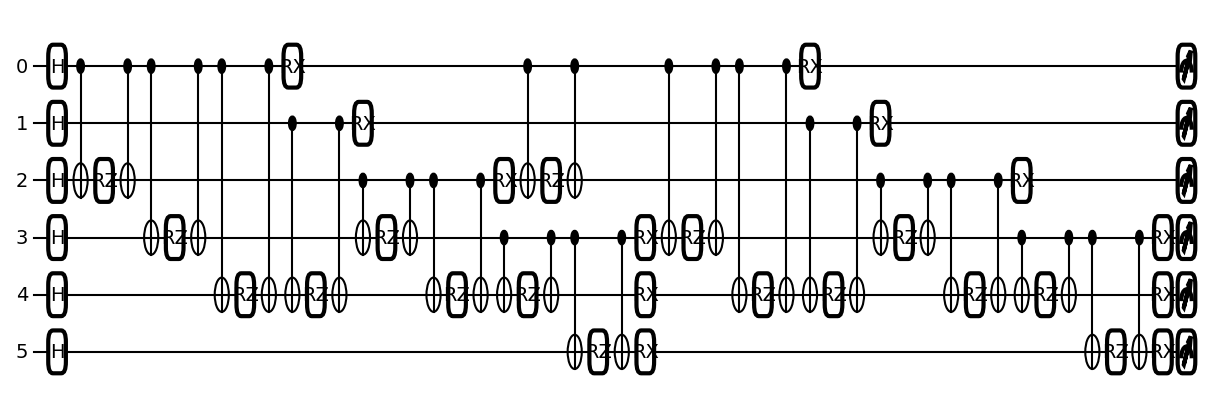




------------------------------------------------------------
Graph: Random Dense(6)   |   p = 2
------------------------------------------------------------

ASCII Circuit Diagram:
----------------------
0: ──H─╭●────────────╭●─╭●────────────╭●──RX(1.10)───────────────────────────────────────────── ···
1: ──H─│─────────────│──│─────────────│──╭●───────────────────╭●─╭●────────────╭●─╭●─────────── ···
2: ──H─│─────────────│──│─────────────│──╰X─────────RZ(-0.63)─╰X─│─────────────│──│──────────── ···
3: ──H─╰X──RZ(-0.63)─╰X─│─────────────│──────────────────────────╰X──RZ(-0.63)─╰X─│──────────── ···
4: ──H──────────────────│─────────────│───────────────────────────────────────────│──────────── ···
5: ──H──────────────────╰X──RZ(-0.63)─╰X──────────────────────────────────────────╰X──RZ(-0.63) ···

0: ··· ──────────────────────────────────────╭●────────────╭●─╭●────────────╭●──RX(0.73) ···
1: ··· ─╭●──RX(1.10)─────────────────────────│─────────────│──│─────────────│──╭●─────── ···
2: ···

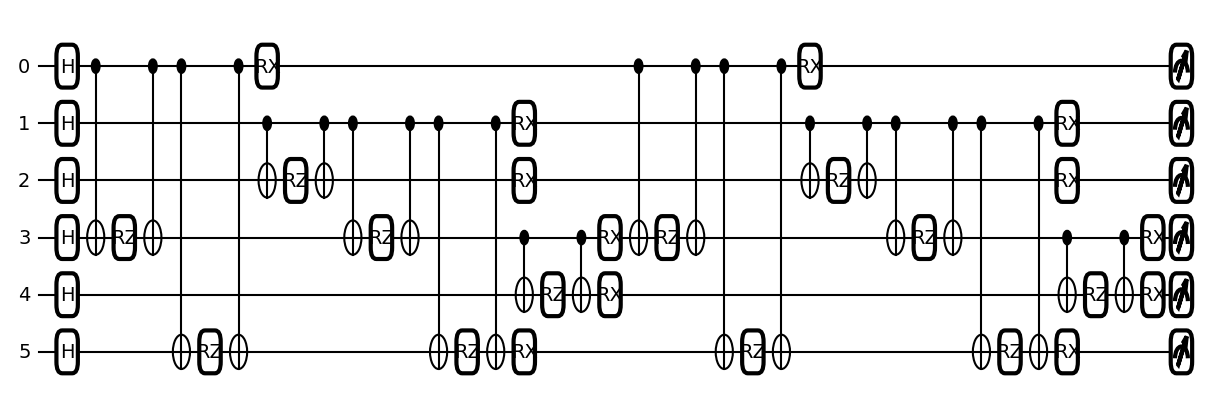

In [10]:
# --- Loop to print QAOA circuits for all graphs ---

for p in [1, 2]:
    print("\n" + "="*80)
    print(f"QAOA CIRCUITS FOR p = {p}")
    print("="*80)

    for graph_name, G in graphs.items():
        print("\n" + "-"*60)
        print(f"Graph: {graph_name}   |   p = {p}")
        print("-"*60)

        # extract optimized parameters
        params, _ = results[graph_name][f"p{p}"]
        gammas = params[0]
        betas = params[1]

        # ASCII circuit
        print("\nASCII Circuit Diagram:")
        print("----------------------")
        plot_qaoa_circuit_ascii(gammas, betas, G)

        # Matplotlib circuit
        print("\nMatplotlib Circuit Diagram:")
        print("---------------------------")
        plot_qaoa_circuit_mpl(gammas, betas, G)

        print("\n")  # spacing
